In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from torch.utils.data import DataLoader
import random

from cam_net import AlexNet_GAP
from cam_utils import label_data, overlay_cam_with_centroid, ResizeAndPad, ImageListDataset

In [20]:
dataDir='data'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
all_data = label_data(coco)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [22]:
# Cross Validation
random.shuffle(all_data)
split = int(0.8 * len(all_data))
train_data, val_data = all_data[:split], all_data[split:]

# Transform
transform = transforms.Compose([
    ResizeAndPad(),
    transforms.ToTensor(),
])

# Datasets
train_dataset = ImageListDataset(train_data, dataDir, transform)
val_dataset = ImageListDataset(val_data, dataDir, transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet_GAP(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = []
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss", color='blue')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

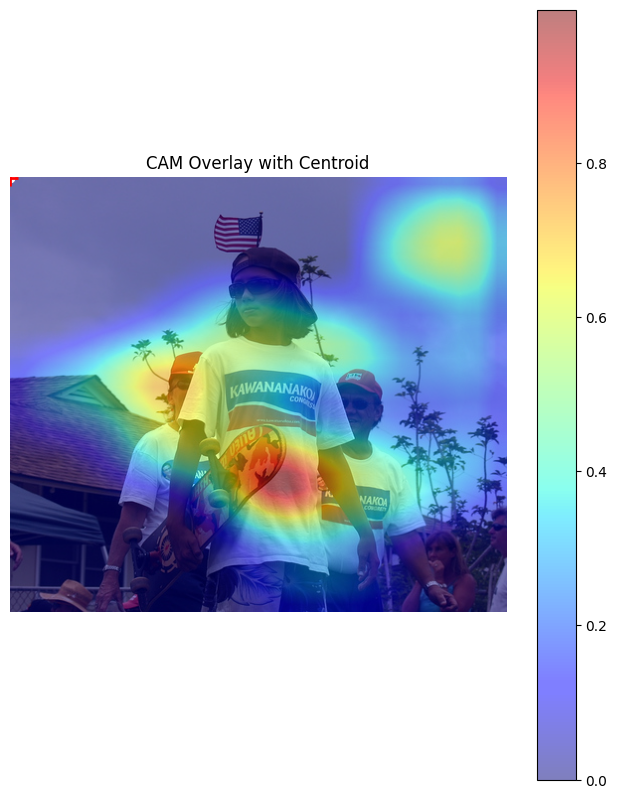

In [65]:
testimage = Image.open(f'{dataDir}/images/{all_data[random.randint(0, len(all_data) - 1)][0]}').convert("RGB")
output = model(transforms.ToTensor()(testimage).unsqueeze(0).to(device))

# Get feature maps and class weights
feature_maps = model.feature_maps.squeeze(0)  # [256, H, W]
weights = model.classifier.weight  # [num_classes, 256]

# Choose predicted class
pred_class = torch.argmax(output, dim=1).item()
class_weights = weights[pred_class]  # [256]

# Compute CAM
cam = torch.einsum("c,chw->hw", class_weights, feature_maps)  # [H, W]
cam = F.relu(cam)
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-5)
overlay_cam_with_centroid(testimage, cam, (0,0))